In [1]:
import torch

from torchvision.io import read_video

In [2]:
frames,_,_ = read_video("data/lipread_mp4/ABOUT/train/ABOUT_00001.mp4", pts_unit='sec', output_format='TCHW')

In [3]:
import matplotlib.pyplot as plt

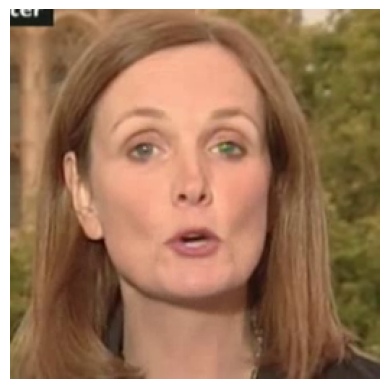

In [4]:
plt.imshow(frames[2].permute(1,2,0))
plt.axis(False)
plt.show()

In [5]:
from torchvision.transforms import v2

In [6]:
video_transform = v2.Resize(size=(4096,4096), antialias=True)

In [7]:
transformed = video_transform(frames)
transformed.shape

torch.Size([29, 3, 4096, 4096])

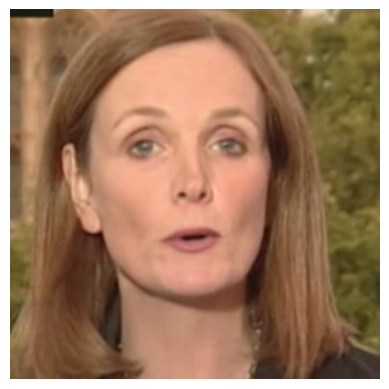

In [8]:
plt.imshow(transformed[5].permute(1,2,0))
plt.axis(False)
plt.show()

In [9]:
import sys

sys.getsizeof(frames)

88

## Setup Training, Testing and Validation DataFrames

In [10]:
import pandas as pd
from typing import Tuple
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm

DATASET_PATH = Path("data/lipread_mp4/")

def process_video(video_path):
    split = video_path.parent
    label = split.parent.name
    return {"path": video_path, "label": label, "split": split.name}

def get_train_val_test_dataframes(dataset_path: str = DATASET_PATH) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Returns train, val, and test dataframes from the dataset.

    Args:
        dataset_path: The path to the dataset.

    Returns:
        Tuple containing the DataFrames consisting of the video paths and label for the train, val, and test sets.
    """

    all_data = {"path": [], "label": [], "split": []}
    current_split_name = None

    dataset_path = Path(dataset_path)  # Convert to Path object

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_video, video_path) for video_path in tqdm(dataset_path.glob("*/*/*.mp4"))]

        for future in tqdm(futures, total=len(futures), desc="Processing videos"):
            video_info = future.result()
            split_name = video_info["path"].parent.name

            all_data["path"].append(video_info["path"])
            all_data["label"].append(video_info["label"])
            all_data["split"].append(video_info["split"])

    all_df = pd.DataFrame(all_data)

    # Split the dataframe into train, val, and test based on 'split.name'
    train_df = all_df[all_df['split'] == 'train'].reset_index(drop=True)
    val_df = all_df[all_df['split'] == 'val'].reset_index(drop=True)
    test_df = all_df[all_df['split'] == 'test'].reset_index(drop=True)

    return train_df, val_df, test_df

# Example usage:
train_df, val_df, test_df = get_train_val_test_dataframes()


/home/anujm/miniconda3/envs/VSR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
538766it [00:48, 11138.18it/s]
Processing videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 538766/538766 [00:06<00:00, 80767.74it/s]


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488766 entries, 0 to 488765
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    488766 non-null  object
 1   label   488766 non-null  object
 2   split   488766 non-null  object
dtypes: object(3)
memory usage: 11.2+ MB


In [12]:
len(test_df["label"].unique())

500

In [13]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    25000 non-null  object
 1   label   25000 non-null  object
 2   split   25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [14]:
val_df.tail()

,path,label,split
24995,data/lipread_mp4/ATTACK/val/ATTACK_00029.mp4,ATTACK,val
24996,data/lipread_mp4/ATTACK/val/ATTACK_00001.mp4,ATTACK,val
24997,data/lipread_mp4/ATTACK/val/ATTACK_00040.mp4,ATTACK,val
24998,data/lipread_mp4/ATTACK/val/ATTACK_00007.mp4,ATTACK,val
24999,data/lipread_mp4/ATTACK/val/ATTACK_00049.mp4,ATTACK,val


In [15]:
train_df.to_pickle("dataframe/train_df_complete.pkl")

In [16]:
test_df.to_pickle("dataframe/test_df_complete.pkl")
val_df.to_pickle("dataframe/val_df_complete.pkl")

In [17]:
pd.read_pickle("dataframe/train_df_complete.pkl")

,path,label,split
0,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00738...,HUNDREDS,train
1,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00206...,HUNDREDS,train
2,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00502...,HUNDREDS,train
3,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00345...,HUNDREDS,train
4,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00852...,HUNDREDS,train
...,...,...,...
488761,data/lipread_mp4/ATTACK/train/ATTACK_00992.mp4,ATTACK,train
488762,data/lipread_mp4/ATTACK/train/ATTACK_00733.mp4,ATTACK,train
488763,data/lipread_mp4/ATTACK/train/ATTACK_00997.mp4,ATTACK,train
488764,data/lipread_mp4/ATTACK/train/ATTACK_00049.mp4,ATTACK,train


In [1]:
import pandas as pd
import numpy as np
from typing import Tuple

def reduce_video_dataset(n_classes: int=500, 
                         n_rows_train: int=None, 
                         n_rows_val: int=None,
                         reduce_test: bool=True) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    # Create annotation
    annotation = f"{n_classes}lab"
    
    train_df_complete = pd.read_pickle("dataframe/train_df_complete.pkl")
    test_df_complete = pd.read_pickle("dataframe/test_df_complete.pkl")
    val_df_complete = pd.read_pickle("dataframe/val_df_complete.pkl")

    labels_trimmed = train_df_complete['label'].unique()[:n_classes]

    # Save labels 
    np.save(file=f"labels/labels_{annotation}", arr=np.array(labels_trimmed), allow_pickle=True)

    train_df_reduced = train_df_complete[train_df_complete['label'].isin(labels_trimmed)]
    test_df_reduced = test_df_complete[test_df_complete['label'].isin(labels_trimmed)]
    val_df_reduced = val_df_complete[val_df_complete['label'].isin(labels_trimmed)]

    if n_rows_train:
        train_df_reduced = train_df_reduced.groupby('label').head(n_rows_train)
        annotation += f"_{n_rows_train}train"

    if n_rows_val:
        val_df_reduced = val_df_reduced.groupby('label').head(n_rows_val)
        annotation += f"_{n_rows_val}val"

        if reduce_test:
            test_df_reduced = test_df_reduced.groupby('label').head(n_rows_val)
            annotation += f"_{n_rows_val}test"

    # Save the dataframes
    train_df_reduced.to_pickle(f'dataframe/train_df_{annotation}.pkl')
    test_df_reduced.to_pickle(f'dataframe/test_df_{annotation}.pkl')
    val_df_reduced.to_pickle(f'dataframe/val_df_{annotation}.pkl')
    
    return train_df_reduced, val_df_reduced, test_df_reduced

In [3]:
a,b,c = reduce_video_dataset(n_classes=50,
                            n_rows_train=1000,
                            n_rows_val=50)

a

,path,label,split
0,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00738...,HUNDREDS,train
1,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00206...,HUNDREDS,train
2,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00502...,HUNDREDS,train
3,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00345...,HUNDREDS,train
4,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00852...,HUNDREDS,train
...,...,...,...
48957,data/lipread_mp4/GREAT/train/GREAT_00238.mp4,GREAT,train
48958,data/lipread_mp4/GREAT/train/GREAT_00243.mp4,GREAT,train
48959,data/lipread_mp4/GREAT/train/GREAT_00237.mp4,GREAT,train
48960,data/lipread_mp4/GREAT/train/GREAT_00744.mp4,GREAT,train


In [20]:
np.load('labels/labels_50lab.npy', allow_pickle=True)

array(['HUNDREDS', 'DEBATE', 'LIVES', 'UNTIL', 'COULD', 'SYRIA', 'PLANS',
       'BRING', 'TEMPERATURES', 'GIVEN', 'SENIOR', 'CONFLICT', 'ORDER',
       'INDUSTRY', 'NATIONAL', 'QUESTIONS', 'ENGLAND', 'NIGHT', 'WORST',
       'MATTER', 'CONCERNS', 'TIMES', 'LEVEL', 'TAKEN', 'MAJOR',
       'CHANGES', 'LEADERSHIP', 'STAND', 'POWER', 'POSITION', 'MEMBERS',
       'THOUGHT', 'GERMANY', 'GIVING', 'WRONG', 'AGAIN', 'WELFARE',
       'SCHOOL', 'TERMS', 'STAGE', 'THROUGH', 'SPEAKING', 'RECORD',
       'CHARGE', 'BECOME', 'WANTED', 'REFERENDUM', 'NORTH', 'GROUP',
       'GREAT'], dtype=object)

In [22]:
len(b)

1000